# Analysis of outlier proteins/metabolites found among samples with high HbA1C in the Arivale dataset

Note: the main idea here is to test various graph analysis methods, not to build a rigorous characterization of Arivale outliers.

In [1]:
# imports
import numpy as np
import pandas as pd
import networkx as nx
import kgfe

## 1. Load data

In [2]:
prots_data = pd.read_csv('../data/prots_hba1c_outliers_2023_07_21.csv', index_col=0)

In [3]:
mets_data = pd.read_csv('../data/mets_hba1c_outliers_2023_07_21.csv', index_col=0)

In [4]:
prots_data.sort_values('outlier_frequency_in_diabetes', ascending=False).head(10)

,name,uniprot,gene_name,outlier_frequency_in_diabetes,outlier_frequency_in_pre_diab
index,,,,,
CVD3_Q99988,CVD3_Q99988,Q99988,GDF15,0.302521,0.150538
CVD3_P07339,CVD3_P07339,P07339,CTSD,0.243697,0.139785
CVD2_P18510,CVD2_P18510,P18510,IL1RN,0.226891,0.086022
CVD2_Q9UJM8,CVD2_Q9UJM8,Q9UJM8,HAO1,0.218487,0.107527
CVD2_Q9BYF1,CVD2_Q9BYF1,Q9BYF1,ACE2,0.210084,0.139785
CVD2_P35442,CVD2_P35442,P35442,THBS2,0.210084,0.075269
CVD2_Q96D42,CVD2_Q96D42,Q96D42,HAVCR1,0.210084,0.053763
INF_P78556,INF_P78556,P78556,CCL20,0.210084,0.139785
INF_Q9H5V8,INF_Q9H5V8,Q9H5V8,CDCP1,0.193277,0.129032


In [5]:
mets_data.sort_values('outlier_frequency_in_diabetes', ascending=False)

,index,CHEMBL,KEGG,PUBCHEM,outlier_frequency_in_diabetes,outlier_frequency_in_pre_diab
CHEMICAL_ID,,,,,,
572,glucose,CHEMBL1222250,C00031,5793.0,0.789916,0.193548
803,mannose,CHEMBL469448,C00159,18950.0,0.588235,0.172043
100020419,1-carboxyethylphenylalanine,NaN,NaN,NaN,0.554622,0.311828
823,pyruvate,CHEMBL1162144,C00022,1060.0,0.436975,0.129032
999946512,X - 21467,NaN,NaN,NaN,0.403361,0.182796
...,...,...,...,...,...,...
100004329,"sphingomyelin (d18:2/16:0, d18:1/16:1)*",NaN,NaN,NaN,0.000000,0.043011
100004509,S-allylcysteine,CHEMBL1592541,NaN,98280.0,0.000000,0.000000
100004555,benzoylcarnitine*,NaN,NaN,NaN,0.000000,0.000000


In [6]:
(prots_data.outlier_frequency_in_diabetes> 0).sum()

252

In [7]:
top_prots = prots_data.sort_values('outlier_frequency_in_diabetes', ascending=False).head(20)
top_mets = mets_data.sort_values('outlier_frequency_in_diabetes', ascending=False).head(20)

## 2. Load SPOKE

In [8]:
import igraph as ig

In [9]:
spoke_graph = kgfe.spoke_loader.load_spoke_igraph('../../graph_utils/spoke_2023_human.json.gz', directed=True,
                                                    verbose=False)

In [10]:
spoke_graph_ud = spoke_graph.copy()
spoke_graph_ud.to_undirected(combine_edges='first')
spoke_graph_ud.simplify(combine_edges='first')

In [11]:
# TODO: identify the largest connected component
ccs = spoke_graph_ud.connected_components()

In [12]:
names_to_ids = kgfe.graph_info.get_names_to_ids(spoke_graph_ud)

### Map proteins and metabolites to SPOKE nodes

In [14]:
len(names_to_ids)

596580

In [15]:
uniprot_to_ids = kgfe.graph_info.spoke_identifiers_to_ids(spoke_graph_ud, 'Protein')

In [16]:
chembl_to_ids = kgfe.graph_info.spoke_identifiers_to_ids(spoke_graph_ud, 'Compound')

In [17]:
high_prots = top_prots['uniprot']
high_chems = top_mets[(~top_mets['CHEMBL'].isna())]['CHEMBL']


In [18]:
high_chems_kegg = top_mets[(~top_mets['KEGG'].isna())]['KEGG']


In [19]:
high_prots_spoke_ids = [uniprot_to_ids[x] for x in high_prots]

In [20]:
all_prots_spoke_ids = [uniprot_to_ids[x] for x in prots_data['uniprot'] if x in uniprot_to_ids]

In [21]:
high_prots_spoke_ids

['8152',
 '284',
 '10902',
 '1552',
 '20385',
 '4223',
 '7712',
 '11708',
 '16152',
 '2587',
 '4552',
 '4243',
 '12029',
 '754',
 '3895',
 '3398',
 '17811',
 '519',
 '3398',
 '17445']

In [22]:
high_chems_spoke_ids = [(x, chembl_to_ids[x]) for x in high_chems if  x in chembl_to_ids]

In [46]:
high_chems_spoke_ids

[('CHEMBL1222250', '520105'),
 ('CHEMBL469448', '521206'),
 ('CHEMBL539648', '538768'),
 ('CHEMBL3137744', '533705')]

Note: many chems were not able to be mapped onto SPOKE.

In [23]:
high_chems_kegg_spoke_ids = [(x, chembl_to_ids[x]) for x in top_mets['KEGG'] if  x in chembl_to_ids]

In [24]:
len([x for x in chembl_to_ids.keys() if x.startswith('C0')])

2055

In [25]:
high_chems_kegg_spoke_ids

[('C00031', '541468'),
 ('C00159', '541617'),
 ('C00186', '541419'),
 ('C00794', '541530')]

In [26]:
len(all_prots_spoke_ids)

1186

### TODO: figure out how many of all proteins/metabolites map onto Arivale

### TODO: Compare the identified nodes against a null model.

In [27]:
spoke_graph_ud_connected = spoke_graph_ud.subcomponent(high_prots_spoke_ids[0])
spoke_graph_ud_connected = spoke_graph_ud.induced_subgraph(spoke_graph_ud_connected)

In [28]:
len(high_prots_spoke_ids)

20

In [29]:
%prun high_prots_stats = kgfe.explanations.graph_node_stats(spoke_graph_ud_connected, list(set(high_prots_spoke_ids)))

         450 function calls in 0.152 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       18    0.112    0.006    0.112    0.006 {method 'get_shortest_paths' of 'igraph._igraph.GraphBase' objects}
        1    0.039    0.039    0.039    0.039 {method 'transitivity_local_undirected' of 'igraph._igraph.GraphBase' objects}
        1    0.001    0.001    0.152    0.152 explanations.py:100(graph_node_stats)
        4    0.000    0.000    0.000    0.000 {method 'reduce' of 'numpy.ufunc' objects}
        3    0.000    0.000    0.000    0.000 _methods.py:66(_count_reduce_items)
      189    0.000    0.000    0.000    0.000 explanations.py:132(<genexpr>)
       18    0.000    0.000    0.000    0.000 {method 'extend' of 'list' objects}
        1    0.000    0.000    0.152    0.152 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 _methods.py:196(_var)
        2    0.000    0.000    0.000    0.000 _method

In [30]:
%prun high_prots_null_results = kgfe.explanations.null_graph_stats(spoke_graph_ud_connected, 'Protein', len(high_prots_spoke_ids))

         635768 function calls (635764 primitive calls) in 133.642 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      100  130.212    1.302  130.212    1.302 {method 'distances' of 'igraph._igraph.GraphBase' objects}
      100    2.516    0.025    2.516    0.025 {method 'transitivity_local_undirected' of 'igraph._igraph.GraphBase' objects}
        1    0.642    0.642    0.860    0.860 graph_info.py:236(nodes_in_category)
   597317    0.216    0.000    0.216    0.000 {method 'attributes' of 'igraph.Vertex' objects}
     1900    0.010    0.000    0.010    0.000 {method 'extend' of 'list' objects}
      100    0.009    0.000  132.772    1.328 explanations.py:100(graph_node_stats)
      100    0.004    0.000    0.004    0.000 {method 'degree' of 'igraph._igraph.GraphBase' objects}
      400    0.004    0.000    0.004    0.000 {method 'reduce' of 'numpy.ufunc' objects}
     2000    0.003    0.000    0.003    0.000 {method 'ad

In [31]:
%prun high_prots_null_results_arivale_prots = kgfe.explanations.null_graph_stats(spoke_graph_ud_connected, 'Protein', len(high_prots_spoke_ids),\
                                                                   ids_subset=all_prots_spoke_ids)

         18313 function calls in 73.643 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       98   69.925    0.714   69.925    0.714 {method 'distances' of 'igraph._igraph.GraphBase' objects}
      100    3.487    0.035    3.487    0.035 {method 'transitivity_local_undirected' of 'igraph._igraph.GraphBase' objects}
       36    0.177    0.005    0.177    0.005 {method 'get_shortest_paths' of 'igraph._igraph.GraphBase' objects}
     1898    0.012    0.000    0.012    0.000 {method 'extend' of 'list' objects}
      100    0.009    0.000   73.633    0.736 explanations.py:100(graph_node_stats)
     2000    0.005    0.000    0.005    0.000 {method 'add' of 'set' objects}
      400    0.004    0.000    0.004    0.000 {method 'reduce' of 'numpy.ufunc' objects}
      100    0.004    0.000    0.004    0.000 {method 'degree' of 'igraph._igraph.GraphBase' objects}
      100    0.003    0.000    0.004    0.000 _methods.py:196(_var)
  

In [32]:
high_prots_null_results = pd.DataFrame(high_prots_null_results)


In [33]:
high_prots_null_results.mean()

average_pairwise_distance      2.555316
degree_mean                  195.694000
degree_std                   236.611298
clustering                     0.278424
dtype: float64

In [34]:
import matplotlib.pyplot as plt

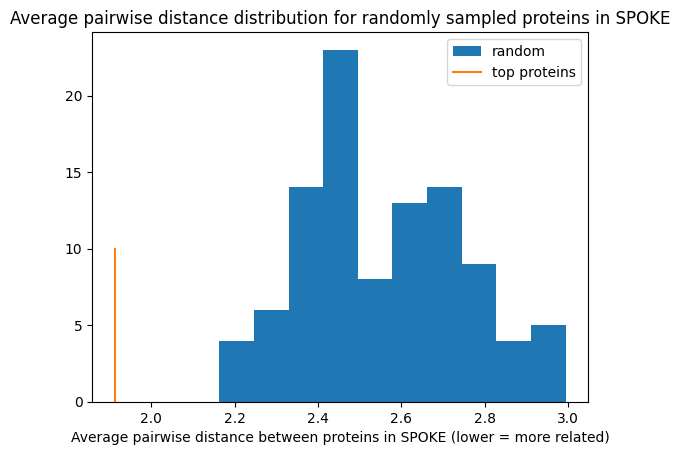

In [35]:
plt.hist(high_prots_null_results.average_pairwise_distance, bins=10, label='random')
plt.title('Average pairwise distance distribution for randomly sampled proteins in SPOKE')
plt.plot([high_prots_stats['average_pairwise_distance'], high_prots_stats['average_pairwise_distance']], [0, 10], label='top proteins')
plt.xlabel('Average pairwise distance between proteins in SPOKE (lower = more related)')
plt.legend()

In [36]:
high_prots_null_results_arivale_prots = pd.DataFrame(high_prots_null_results_arivale_prots)


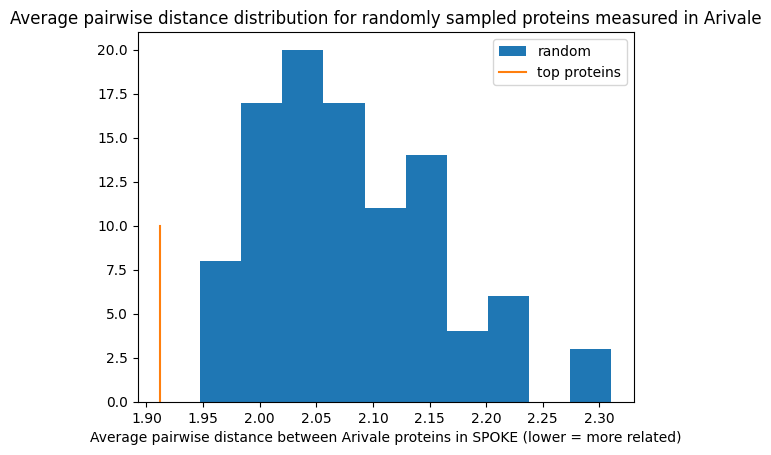

In [37]:
plt.hist(high_prots_null_results_arivale_prots.average_pairwise_distance, bins=10, label='random')
plt.title('Average pairwise distance distribution for randomly sampled proteins measured in Arivale')
plt.plot([high_prots_stats['average_pairwise_distance'], high_prots_stats['average_pairwise_distance']], [0, 10], label='top proteins')
plt.xlabel('Average pairwise distance between Arivale proteins in SPOKE (lower = more related)')
plt.legend()

## Compare outlier degree distributions against degree distributions from all arivale proteins

In [40]:
prot_degrees = spoke_graph_ud.degree(all_prots_spoke_ids)

In [41]:
sample_degrees = spoke_graph_ud.degree(high_prots_spoke_ids)

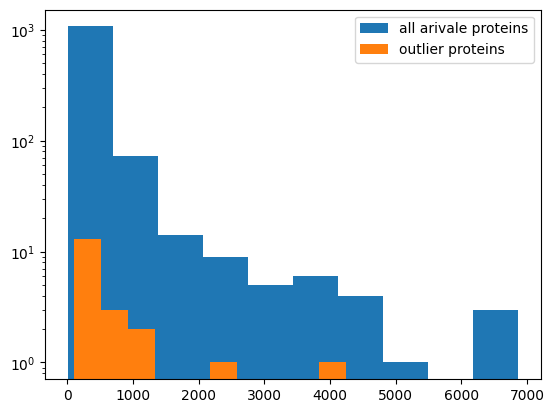

In [45]:
plt.hist(prot_degrees, label='all arivale proteins')
plt.hist(sample_degrees, label='outlier proteins')
plt.yscale('log')
plt.legend()

This means that it's not just the outliers being